In [ ]:
#Team: Aditi Goel
#Members: 1. Aditi Goel
#2. Dr. Anil Kumar
#3. Sonakshi Mehrotra
#4. Jaya Kamboj

In [9]:
#Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd

# Setting image size for EfficientNetB3
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32

# Paths for data directories
train_data_dir = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train'
test_data_dir = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test'

# Loading EfficientNetB3 without top for feature extraction
print("Loading pre-trained model...")
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Creating feature extraction model
feature_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

def load_and_preprocess_images(data_dir):
    """Load images and preprocess for feature extraction, including subdirectories."""
    images = []
    filenames = []

    if not os.path.isdir(data_dir):
        print(f"Error: Directory not found: {data_dir}")
        return np.array(images), filenames

    for root, _, files in os.walk(data_dir):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.gif')):
                img_path = os.path.join(root, filename)
                try:
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)
                    img_array = preprocess_input(img_array)
                    images.append(img_array[0])
                    filenames.append(os.path.relpath(img_path, data_dir))
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    if images:
        return np.array(images), filenames
    else:
        return np.array([]), filenames

def extract_features_batch(images, model, batch_size=32):
    """Extract features in batches"""
    if len(images) == 0:
        print("No images to extract features from.")
        return np.array([])

    features = []
    images_array = np.array(images)
    for i in range(0, len(images_array), batch_size):
        batch = images_array[i:i+batch_size]
        batch_features = model.predict(batch, verbose=0)
        features.extend(batch_features)
    return np.array(features)

def generate_classification_report(y_true, y_pred, dataset_name, model_name):
    """Generate and print classification report"""
    print(f"\n{'='*60}")
    print(f"{dataset_name.upper()} SET CLASSIFICATION REPORT - {model_name}")
    print(f"{'='*60}")
    
    # Converting predictions to binary (1 for inlier/soil, 0 for outlier/not-soil)
    y_pred_binary = (y_pred == 1).astype(int)
    y_true_binary = np.ones_like(y_true).astype(int)  # All true samples are soil (inliers)
    
    # Calculating accuracy display
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report display
    report = classification_report(
        y_true_binary, 
        y_pred_binary, 
        target_names=['Not Soil', 'Soil'],
        digits=4
    )
    print(report)
    
    # Confusion matrix display
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    print(f"Confusion Matrix:")
    print(f"                 Predicted")
    print(f"                Not Soil  Soil")
    print(f"Actual Not Soil    {cm[0,0]:4d}    {cm[0,1]:4d}")
    print(f"       Soil        {cm[1,0]:4d}    {cm[1,1]:4d}")
    
    # Additional metrics display
    total_samples = len(y_pred_binary)
    correctly_classified_soil = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
    misclassified_as_not_soil = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    
    print(f"\nDetailed Analysis:")
    print(f"Total samples: {total_samples}")
    print(f"Correctly classified as Soil: {correctly_classified_soil} ({correctly_classified_soil/total_samples*100:.2f}%)")
    print(f"Misclassified as Not Soil: {misclassified_as_not_soil} ({misclassified_as_not_soil/total_samples*100:.2f}%)")
    
    return accuracy, report, cm

# Loading training data (all soil images)
print("Loading training images...")
train_images, train_filenames = load_and_preprocess_images(train_data_dir)
print(f"Loaded {len(train_images)} training images")

# Extracting features from training images
print("Extracting features from training images...")
if len(train_images) > 0:
    train_features = extract_features_batch(train_images, feature_model, BATCH_SIZE)
    print(f"Extracted features shape: {train_features.shape}")
else:
    train_features = np.array([])
    print("No features extracted.")

# Proceeding after training features were extracted
if train_features.shape[0] > 0:
    # Splitting training data into train/validation
    if train_features.shape[0] > 1:
        train_feat, val_feat, train_files, val_files = train_test_split(
            train_features, train_filenames, test_size=0.2, random_state=42
        )
        print(f"Training features shape (split): {train_feat.shape}")
        print(f"Validation features shape (split): {val_feat.shape}")
    else:
        train_feat = train_features
        val_feat = np.array([])
        train_files = train_filenames
        val_files = []
        print("Only one training sample, no validation split.")

    # Standardizing features
    scaler = StandardScaler()
    train_feat_scaled = scaler.fit_transform(train_feat)
    if val_feat.shape[0] > 0:
        val_feat_scaled = scaler.transform(val_feat)
    else:
        val_feat_scaled = np.array([])

    # Anomaly detection algorithms
    anomaly_detectors = {
        'OneClassSVM_rbf': OneClassSVM(kernel='rbf', gamma='scale', nu=0.3),
        'OneClassSVM_linear': OneClassSVM(kernel='linear', nu=0.3),
        'IsolationForest': IsolationForest(contamination=0.3, random_state=42),
    }

    # Processing: Train and evaluate models
    print("\nTraining anomaly detection models...")
    trained_models = {}
    validation_scores = {}
    model_reports = {}

    for name, model in anomaly_detectors.items():
        print(f"\nTraining {name}...")
        
        try:
            model.fit(train_feat_scaled)
            trained_models[name] = model
            
            # Generating predictions for training set
            train_predictions = model.predict(train_feat_scaled)
            
            # Generating classification report for training set
            train_accuracy, train_report, train_cm = generate_classification_report(
                np.ones(len(train_predictions)), train_predictions, "TRAINING", name
            )
            
            # Storing results
            model_reports[name] = {
                'train_accuracy': train_accuracy,
                'train_report': train_report,
                'train_cm': train_cm
            }
            
            # Validating on validation set if available
            if val_feat_scaled.shape[0] > 0:
                val_predictions = model.predict(val_feat_scaled)
                
                # Generating classification report for validation set
                val_accuracy, val_report, val_cm = generate_classification_report(
                    np.ones(len(val_predictions)), val_predictions, "VALIDATION", name
                )
                
                # Storing validation results
                model_reports[name].update({
                    'val_accuracy': val_accuracy,
                    'val_report': val_report,
                    'val_cm': val_cm
                })
                
                # Using validation accuracy for model selection
                validation_scores[name] = val_accuracy
                
            else:
                # Using training accuracy if no validation set
                validation_scores[name] = train_accuracy
                print(f"\nNo validation data available for {name}. Using training accuracy.")
                
        except Exception as e:
            print(f"Error training {name}: {e}")
            trained_models[name] = None
            validation_scores[name] = 0.0

    # Selecting best model based on validation performance
    if validation_scores and max(validation_scores.values()) > 0:
        best_model_name = max(validation_scores, key=validation_scores.get)
        if trained_models[best_model_name] is not None:
            best_model = trained_models[best_model_name]
            print(f"\n{'='*80}")
            print(f"BEST MODEL SELECTED: {best_model_name}")
            print(f"Validation Score: {validation_scores[best_model_name]:.4f}")
            print(f"{'='*80}")
        else:
            print("\nBest performing model failed to train. Using first successful model.")
            best_model_name = None
            for name, model in trained_models.items():
                if model is not None:
                    best_model_name = name
                    best_model = model
                    break
            if best_model_name is None:
                print("No model trained successfully.")
                best_model = None
    else:
        print("\nNo valid models. Cannot proceed.")
        best_model = None

    # Summary of all models
    print(f"\n{'='*80}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")
    print(f"{'Model':<20} {'Train Acc':<12} {'Val Acc':<12} {'Status'}")
    print("-" * 60)
    
    for name in anomaly_detectors.keys():
        if name in model_reports:
            train_acc = model_reports[name]['train_accuracy']
            val_acc = model_reports[name].get('val_accuracy', 'N/A')
            status = 'Success' if trained_models[name] is not None else 'Failed'
            
            if isinstance(val_acc, float):
                print(f"{name:<20} {train_acc:<12.4f} {val_acc:<12.4f} {status}")
            else:
                print(f"{name:<20} {train_acc:<12.4f} {val_acc:<12} {status}")
        else:
            print(f"{name:<20} {'Failed':<12} {'Failed':<12} Failed")

    # Model Selection: Load and predict on test data if best model is available
    if best_model is not None:
        print(f"\n{'='*80}")
        print("TESTING PHASE")
        print(f"{'='*80}")
        
        # Loading test data
        print("Loading test images...")
        test_images, test_filenames = load_and_preprocess_images(test_data_dir)
        print(f"Loaded {len(test_images)} test images")

        if len(test_images) > 0:
            # Extracting features from test images
            print("Extracting features from test images...")
            test_features = extract_features_batch(test_images, feature_model, BATCH_SIZE)
            test_features_scaled = scaler.transform(test_features)
            print(f"Test features shape: {test_features.shape}")

            # Making predictions on test data
            print("Making predictions on test data...")
            test_predictions = best_model.predict(test_features_scaled)

            # Converting predictions to binary labels
            pred_labels = (test_predictions == 1).astype(int)

            # Calculating prediction statistics
            soil_count = np.sum(pred_labels)
            not_soil_count = len(pred_labels) - soil_count

            print(f"\nTest Prediction Results using {best_model_name}:")
            print(f"Total test images: {len(test_predictions)}")
            print(f"Predicted as Soil: {soil_count} ({soil_count/len(pred_labels)*100:.1f}%)")
            print(f"Predicted as Not Soil: {not_soil_count} ({not_soil_count/len(pred_labels)*100:.1f}%)")

            # Getting decision scores for confidence
            if hasattr(best_model, 'decision_function'):
                decision_scores = best_model.decision_function(test_features_scaled)
                decision_scores_array = decision_scores.flatten() if decision_scores.ndim > 1 else decision_scores
                
                # Normalizing scores
                min_score = np.min(decision_scores_array)
                max_score = np.max(decision_scores_array)
                if min_score != max_score:
                    scores_normalized = (decision_scores_array - min_score) / (max_score - min_score)
                else:
                    scores_normalized = np.ones_like(decision_scores_array) * 0.5
            else:
                scores_normalized = np.ones(len(pred_labels)) * 0.5
                decision_scores_array = np.zeros(len(pred_labels))

            # Creating predictions DataFrame
            predictions_df_list = []
            for i, filename in enumerate(test_filenames):
                confidence_value = scores_normalized[i] if pred_labels[i] == 1 else (1 - scores_normalized[i])
                predictions_df_list.append({
                    'filename': filename,
                    'prediction': 'soil' if pred_labels[i] == 1 else 'not_soil',
                    'confidence': confidence_value,
                    'decision_score': decision_scores_array[i]
                })
            
            predictions_df = pd.DataFrame(predictions_df_list)
            
            # Printing detailed predictions
            print(f"\nTop 10 Most Confident Predictions:")
            predictions_df_sorted = predictions_df.sort_values(by='confidence', ascending=False)
            print(f"{'Filename':<30} {'Prediction':<10} {'Confidence':<10} {'Score'}")
            print("-" * 65)
            for _, row in predictions_df_sorted.head(10).iterrows():
                print(f"{row['filename']:<30} {row['prediction']:<10} {row['confidence']:<10.3f} {row['decision_score']:.3f}")
            
            print(f"\nTop 10 Least Confident Predictions:")
            print(f"{'Filename':<30} {'Prediction':<10} {'Confidence':<10} {'Score'}")
            print("-" * 65)
            for _, row in predictions_df_sorted.tail(10).iterrows():
                print(f"{row['filename']:<30} {row['prediction']:<10} {row['confidence']:<10.3f} {row['decision_score']:.3f}")

    print(f"\n{'='*80}")
    print("ANALYSIS COMPLETE")
    print(f"{'='*80}")

else:
    print("\nSkipping analysis due to empty training dataset.")

Loading pre-trained model...
Loading training images...
Loaded 1222 training images
Extracting features from training images...
Extracted features shape: (1222, 1536)
Training features shape (split): (977, 1536)
Validation features shape (split): (245, 1536)

Training anomaly detection models...

Training OneClassSVM_rbf...

TRAINING SET CLASSIFICATION REPORT - OneClassSVM_rbf
Accuracy: 0.6970
              precision    recall  f1-score   support

    Not Soil     0.0000    0.0000    0.0000         0
        Soil     1.0000    0.6970    0.8215       977

    accuracy                         0.6970       977
   macro avg     0.5000    0.3485    0.4107       977
weighted avg     1.0000    0.6970    0.8215       977

Confusion Matrix:
                 Predicted
                Not Soil  Soil
Actual Not Soil       0       0
       Soil         296     681

Detailed Analysis:
Total samples: 977
Correctly classified as Soil: 681 (69.70%)
Misclassified as Not Soil: 296 (30.30%)

VALIDATION SE

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: Undefin


TRAINING SET CLASSIFICATION REPORT - OneClassSVM_linear
Accuracy: 0.5148
              precision    recall  f1-score   support

    Not Soil     0.0000    0.0000    0.0000         0
        Soil     1.0000    0.5148    0.6797       977

    accuracy                         0.5148       977
   macro avg     0.5000    0.2574    0.3399       977
weighted avg     1.0000    0.5148    0.6797       977

Confusion Matrix:
                 Predicted
                Not Soil  Soil
Actual Not Soil       0       0
       Soil         474     503

Detailed Analysis:
Total samples: 977
Correctly classified as Soil: 503 (51.48%)
Misclassified as Not Soil: 474 (48.52%)

VALIDATION SET CLASSIFICATION REPORT - OneClassSVM_linear
Accuracy: 0.5020
              precision    recall  f1-score   support

    Not Soil     0.0000    0.0000    0.0000         0
        Soil     1.0000    0.5020    0.6685       245

    accuracy                         0.5020       245
   macro avg     0.5000    0.2510    0.3342

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: Undefin


TRAINING SET CLASSIFICATION REPORT - IsolationForest
Accuracy: 0.7001
              precision    recall  f1-score   support

    Not Soil     0.0000    0.0000    0.0000         0
        Soil     1.0000    0.7001    0.8236       977

    accuracy                         0.7001       977
   macro avg     0.5000    0.3501    0.4118       977
weighted avg     1.0000    0.7001    0.8236       977

Confusion Matrix:
                 Predicted
                Not Soil  Soil
Actual Not Soil       0       0
       Soil         293     684

Detailed Analysis:
Total samples: 977
Correctly classified as Soil: 684 (70.01%)
Misclassified as Not Soil: 293 (29.99%)

VALIDATION SET CLASSIFICATION REPORT - IsolationForest
Accuracy: 0.6653
              precision    recall  f1-score   support

    Not Soil     0.0000    0.0000    0.0000         0
        Soil     1.0000    0.6653    0.7990       245

    accuracy                         0.6653       245
   macro avg     0.5000    0.3327    0.3995      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

Loaded 967 test images
Extracting features from test images...
Test features shape: (967, 1536)
Making predictions on test data...

Test Prediction Results using OneClassSVM_rbf:
Total test images: 967
Predicted as Soil: 212 (21.9%)
Predicted as Not Soil: 755 (78.1%)

Top 10 Most Confident Predictions:
Filename                       Prediction Confidence Score
-----------------------------------------------------------------
67ecfc4387a35bcfb917f0518ea51b8e.jpg soil       1.000      14.136
f672c3cc395259dc8fd26fa4b64be913.jpg not_soil   1.000      -23.833
f433b4f7ad785de3a12972167265404f.jpg not_soil   1.000      -23.831
4a0e4a07ef645b2e85e5d2aff7ddd79a.jpg not_soil   0.997      -23.712
15ef50eab69d5fce844da1aca2ce626e.jpg not_soil   0.996      -23.695
e12ee564955d5067a78c094083270636.jpg not_soil   0.996      -23.684
2db77ce92cd452efaaaec2736b262e0a.jpg not_soil   0.993      -23.574
0e8eefeed96350ef8bfe38edb9cc098d.jpg not_soil   0.993      -23.559
fb75cee989405ba69565f380dc213462.jpg

Displaying test predictions...


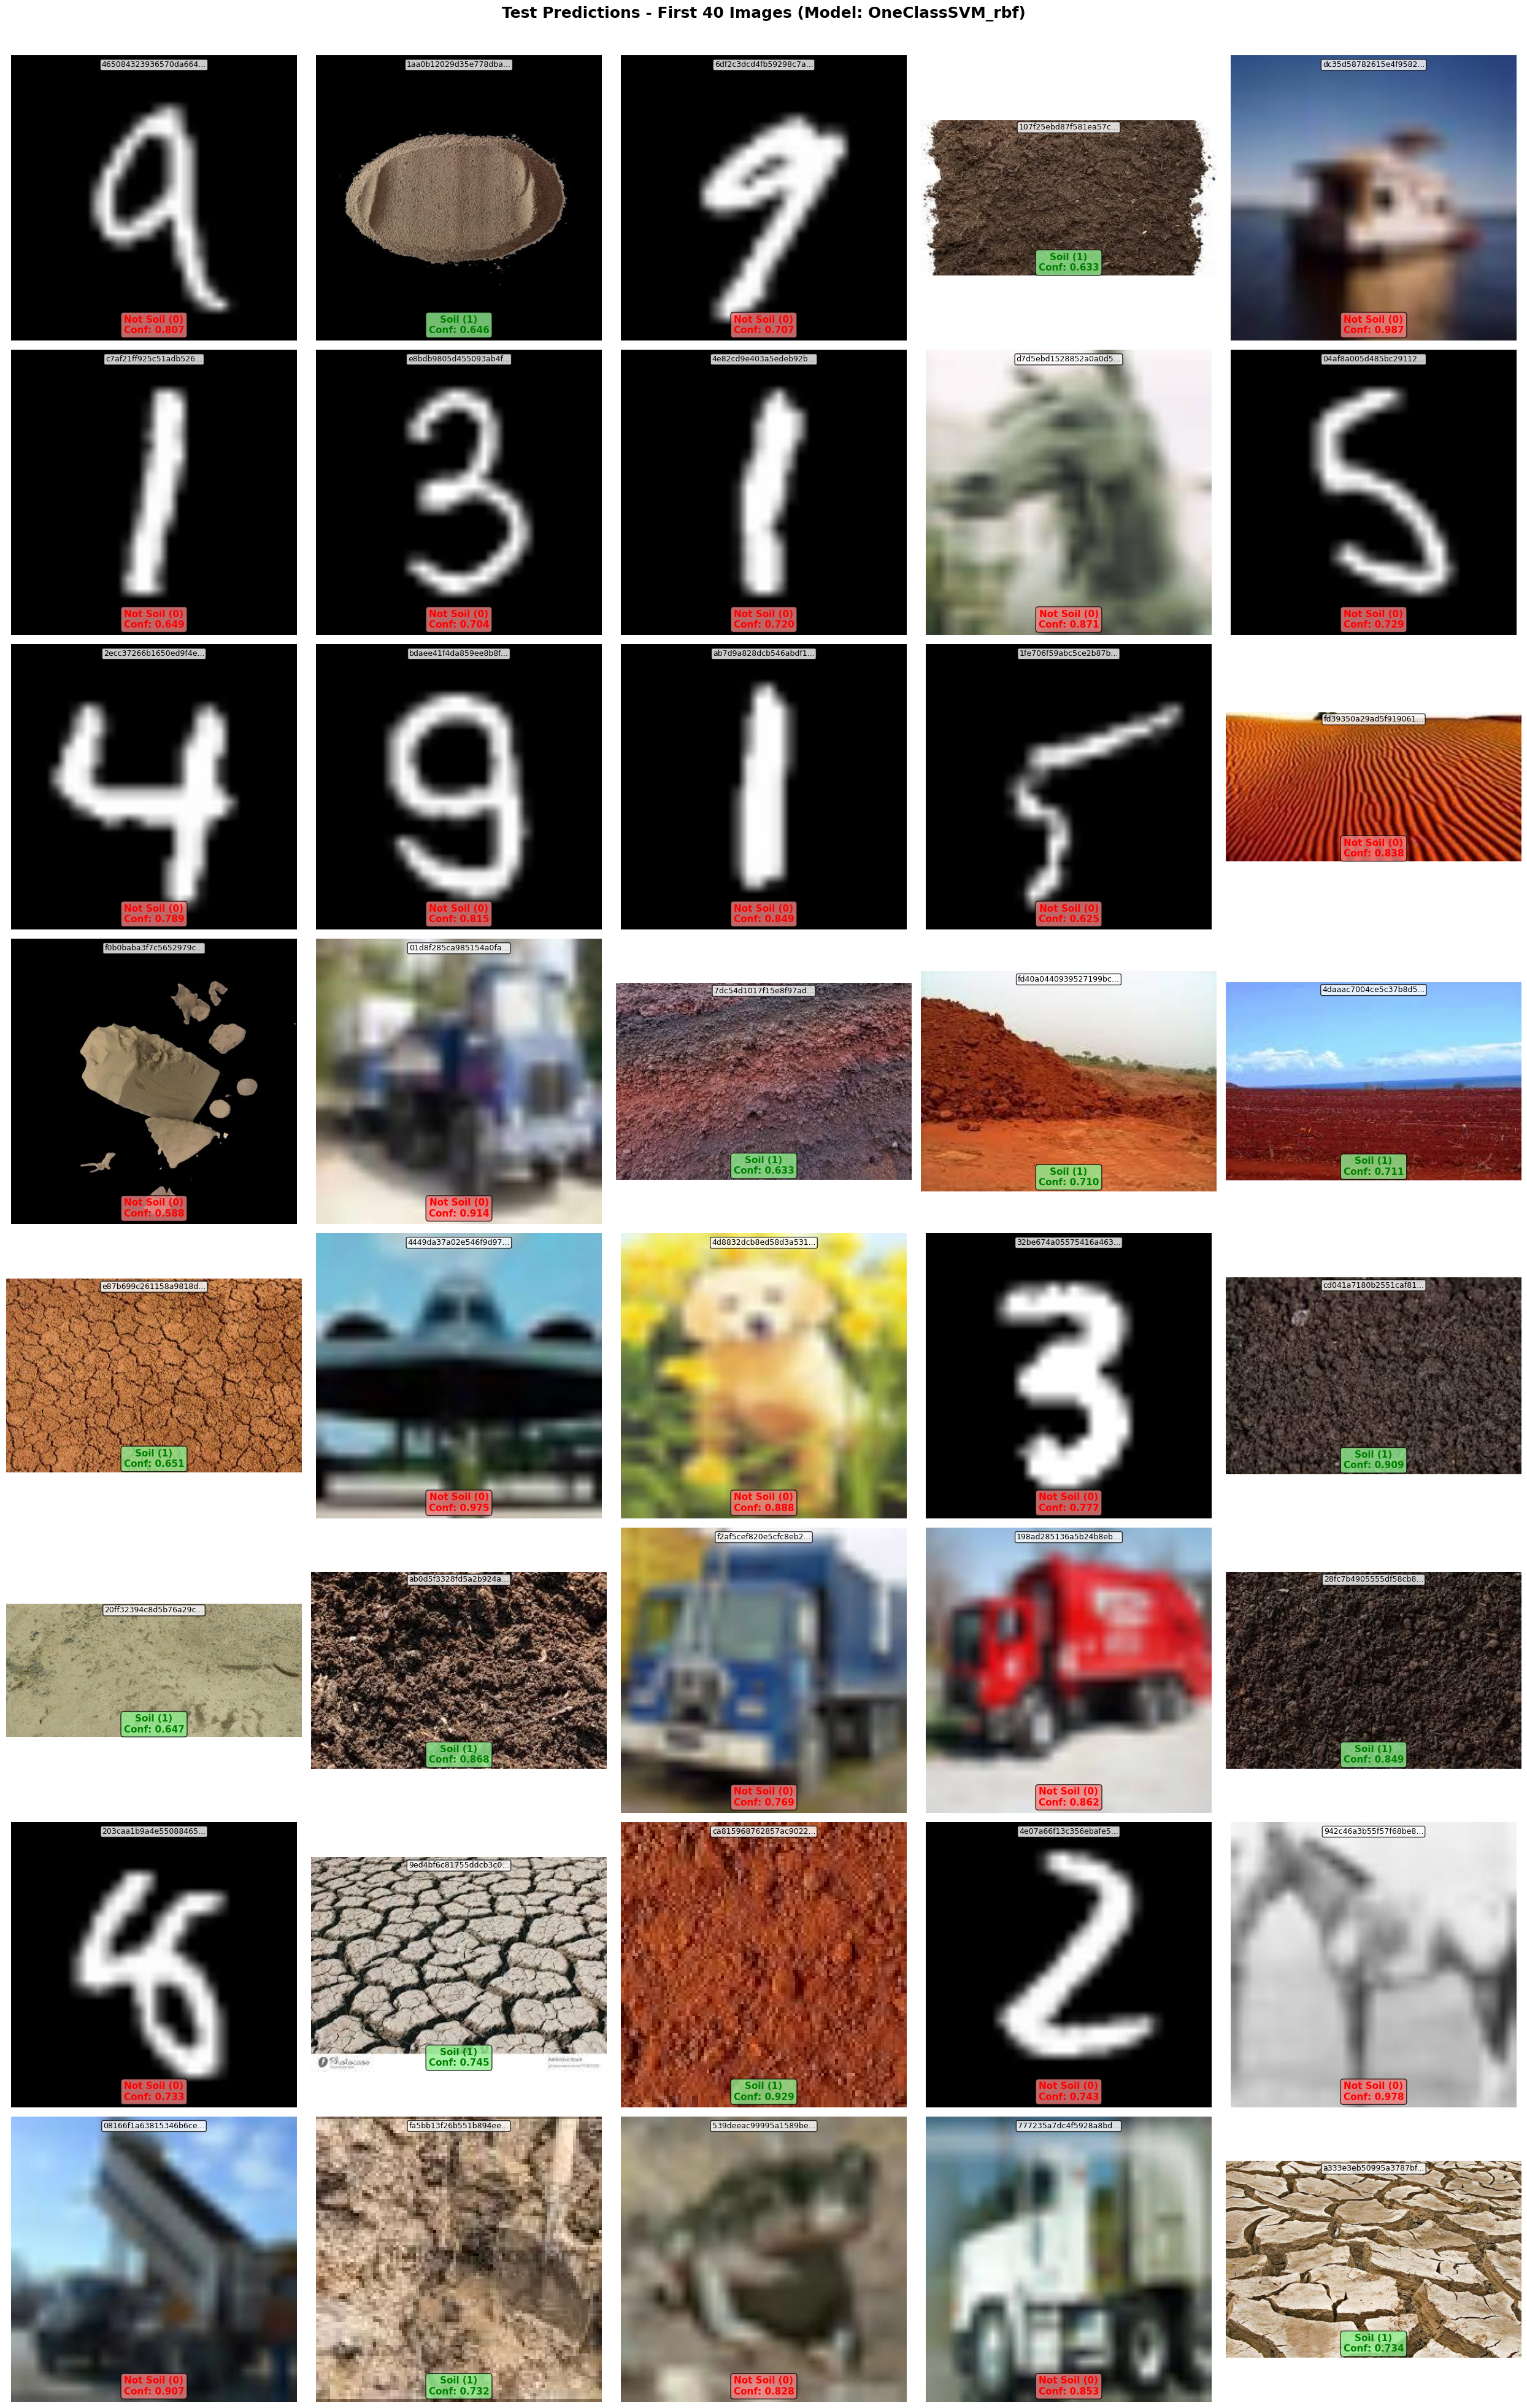


Creating predictions CSV...
First 10 predictions:
                           image_id  label
0  465084323936570da664f0ca8dc90326      0
1  1aa0b12029d35e778dba5bff1255c638      1
2  6df2c3dcd4fb59298c7a73467ea72eeb      0
3  107f25ebd87f581ea57c630a2dcdf50c      1
4  dc35d58782615e4f9582c6b32c8b956e      0
5  c7af21ff925c51adb526c487148bac6d      0
6  e8bdb9805d455093ab4f9503cad8052b      0
7  4e82cd9e403a5edeb92bee62410fd9b1      0
8  d7d5ebd1528852a0a0d5fc8ca175e196      0
9  04af8a005d485bc291124bc288cc8d7f      0

Last 10 predictions:
                             image_id  label
957  ef3b4b2dfe765c89a52fccfa38cfff28      0
958  c1a2b8c41f0f59839128c7846d7eede8      1
959  1388f85526505d12a82facfcec4646b7      0
960  3c22a7725ca35b73b8fababea543b787      0
961  7fabf16fdeed5232985229b5612aa910      0
962  ef98accfe0ea56499544211d9c96056b      1
963  31475ede49d15c279ef04d048c6f059c      1
964  b954b5ae3f475d399bdec4b036ad0628      0
965  f65a998dafe653e19762b202c0ee5815      0
966 

In [12]:
# Test Images Prediction Visualization and CSV Export
# Libraries required
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

# Converting predictions to binary labels (1 for soil, 0 for not soil)
pred_labels = (test_predictions == 1).astype(int)

# Getting decision scores for confidence
if hasattr(best_model, 'decision_function'):
    decision_scores = best_model.decision_function(test_features_scaled)
    decision_scores_array = decision_scores.flatten() if decision_scores.ndim > 1 else decision_scores
    
    # Normalizing scores for confidence calculation
    min_score = np.min(decision_scores_array)
    max_score = np.max(decision_scores_array)
    if min_score != max_score:
        scores_normalized = (decision_scores_array - min_score) / (max_score - min_score)
    else:
        scores_normalized = np.ones_like(decision_scores_array) * 0.5
else:
    scores_normalized = np.ones(len(pred_labels)) * 0.5
    decision_scores_array = np.zeros(len(pred_labels))

# Visualizing 40 test images in 8x5 grid
print("Displaying test predictions...")
fig, axes = plt.subplots(8, 5, figsize=(25, 40))
axes = axes.flatten()

for i in range(40):
    ax = axes[i]
    
    if i >= len(test_filenames):
        ax.axis('off')
        ax.text(0.5, 0.5, 'No Image', ha='center', va='center', fontsize=12, color='gray')
        continue
    
    # Load and display image
    img_path = os.path.join(test_data_dir, test_filenames[i])
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        
        # Calculate confidence for display
        if pred_labels[i] == 1:  # Predicted as Soil
            confidence = scores_normalized[i]
            label = f'Soil (1)\nConf: {confidence:.3f}'
            color = 'green'
            bbox_color = 'lightgreen'
        else:  # Predicted as Not Soil
            confidence = 1 - scores_normalized[i]
            label = f'Not Soil (0)\nConf: {confidence:.3f}'
            color = 'red'
            bbox_color = 'lightcoral'
        
        # Add prediction label with background
        ax.text(0.5, 0.02, label, transform=ax.transAxes, fontsize=11, 
                color=color, weight='bold', ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=bbox_color, alpha=0.8))
        
        # Add filename at the top
        filename_short = test_filenames[i][:20] + '...' if len(test_filenames[i]) > 20 else test_filenames[i]
        ax.text(0.5, 0.98, filename_short, transform=ax.transAxes, fontsize=9, 
                color='black', ha='center', va='top',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
    except Exception as e:
        ax.axis('off')
        ax.text(0.5, 0.5, f'Error Loading\n{test_filenames[i][:15]}...', 
                ha='center', va='center', fontsize=10, color='red')
        print(f"Could not display image {test_filenames[i]}: {e}")

plt.suptitle(f'Test Predictions - First 40 Images (Model: {best_model_name})', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

# Creating CSV with image_id and labels for final submission
print("\nCreating predictions CSV...")

# Extracting image IDs from filenames (removing file extensions)
image_ids = []
for filename in test_filenames:
    # Getting just the filename without path and extension
    base_name = os.path.basename(filename)
    image_id = os.path.splitext(base_name)[0]
    image_ids.append(image_id)

# Creating DataFrame for CSV export
predictions_csv = pd.DataFrame({
    'image_id': image_ids,
    'label': pred_labels  # 0 for not soil, 1 for soil
})

# Display first few rows
print("First 10 predictions:")
print(predictions_csv.head(10))

print(f"\nLast 10 predictions:")
print(predictions_csv.tail(10))

# Summary statistics
soil_count = np.sum(pred_labels)
not_soil_count = len(pred_labels) - soil_count
total_images = len(pred_labels)

print(f"\nPrediction Summary:")
print(f"Total images: {total_images}")
print(f"Soil (label=1): {soil_count} ({soil_count/total_images*100:.1f}%)")
print(f"Not Soil (label=0): {not_soil_count} ({not_soil_count/total_images*100:.1f}%)")

# Saving to CSV
csv_filename = "submission.csv"
predictions_csv.to_csv(csv_filename, index=False)
print(f"\nPredictions saved to: {csv_filename}")

# Creating detailed CSV with additional information
detailed_predictions = pd.DataFrame({
    'image_id': image_ids,
    'label': pred_labels
})

# Display value counts
print(f"\nLabel distribution:")
print(predictions_csv['label'].value_counts().sort_index())

print(f"\nCSV files created successfully!")
print(f"- Basic CSV: {csv_filename} (image_id, label)")